Take sample of training dataset

Architecture from MS

### \\\ Currently used ///

In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import glob
import h5py

/home/fabiane/anaconda2/envs/mort1/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
import os
import sys
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.nn.modules.module import Module

# sklearn functions
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split, KFold, GroupShuffleSplit

# load functions from nitorch
sys.path.insert(0,"/analysis/fabiane/phd/nitorch/")
from nitorch.data import load_nifti
from nitorch.transforms import  ToTensor, SagittalTranslate, SagittalFlip, \
                                AxialTranslate, normalization_factors, Normalize, \
                                IntensityRescale
from nitorch.callbacks import EarlyStopping, ModelCheckpoint
from nitorch.trainer import Trainer
from nitorch.initialization import weights_init
from nitorch.metrics import balanced_accuracy, sensitivity, specificity, auc_score
from nitorch.utils import count_parameters

In [5]:
torch.__version__

'1.0.0'

In [6]:
# use multiple GPUs
gpu = 0
multi_gpus = None#[0, 1, 2]
b = 12
zero_one_normalize = False
zoom = 0.525

dtype = np.float64

In [7]:
# load mask
mask = None

In [8]:
train_h5 = h5py.File("/analysis/ritter/data/ADNI_HDF5/Splits_Eitel/train_AD_CN_2Yr15T_plus_UniqueScreening_quickprep_(96, 114, 96)_reducedValSize.h5", 'r')
val_h5 = h5py.File("/analysis/ritter/data/ADNI_HDF5/Splits_Eitel/val_AD_CN_2Yr15T_plus_UniqueScreening_quickprep_(96, 114, 96)_reducedValSize.h5", 'r')
holdout_h5 = h5py.File("/analysis/ritter/data/ADNI_HDF5/Splits_Eitel/holdout_AD_CN_2Yr15T_plus_UniqueScreening_quickprep_(96, 114, 96)_reducedValSize.h5", 'r')

In [9]:
X_train, y_train = train_h5['X'], train_h5['y']
X_val, y_val = val_h5['X'], val_h5['y']
X_holdout, y_holdout = holdout_h5['X'], holdout_h5['y']

In [10]:
new_ind, _ = train_test_split(np.arange(len(X_train)), train_size=0.2, random_state=42)

/home/fabiane/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [11]:
train_sampler = SubsetRandomSampler(new_ind)

In [12]:
# convert data to numpy arrays
#X_train = np.array(X_train, dtype=dtype)
#y_train = np.array(y_train)

#X_holdout = np.array(X_holdout, dtype=dtype)
#y_holdout = np.array(y_holdout)

In [13]:
class ADNIDataset(Dataset):
    def __init__(self, X, y, transform=None, target_transform=None, mask=None, z_factor=zoom, dtype=np.float32):
        #if np.isnan(X).any() == True:
        #    print("removed nan")
        #    X[np.isnan(X)] = 0.
        self.X = np.copy(X)
        self.y = np.copy(y)
        self.transform = transform
        self.target_transform = target_transform
        self.mask = mask
        self.z_factor = zoom
        self.dtype = dtype
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        image = self.X[idx]
        label = self.y[idx] >= 0.5
        label = torch.FloatTensor([label])
        
        # normalize by max
        image /= np.max(image)
        
        if self.transform:
            image = self.transform(image)
        #if self.target_transform:
        #    label = self.target_transform(label)
            
        sample = {"image" : image,
                 "label" : label}
                 #"idx":idx}
        return sample

In [14]:
augmentations = [SagittalFlip(), SagittalTranslate(dist=(-2, 3))]

In [15]:
if zero_one_normalize:
    intensity = IntensityRescale()
    adni_data_train = ADNIDataset(X_train, y_train, transform=transforms.Compose(augmentations + [intensity, ToTensor()]), mask=mask, dtype=dtype)
    adni_data_val = ADNIDataset(X_val, y_val, transform=transforms.Compose([intensity, ToTensor()]), mask=mask, dtype=dtype)
    adni_data_test = ADNIDataset(X_holdout, y_holdout, transform=transforms.Compose([intensity, ToTensor()]), mask=mask, dtype=dtype)
else:
    adni_data_train = ADNIDataset(X_train, y_train, transform=transforms.Compose(augmentations + [ToTensor()]), mask=mask, dtype=dtype)
    adni_data_val = ADNIDataset(X_val, y_val, transform=transforms.Compose([ToTensor()]), mask=mask, dtype=dtype)
    adni_data_test = ADNIDataset(X_holdout, y_holdout, transform=transforms.Compose([ToTensor()]), mask=mask, dtype=dtype)

torch.Size([1, 96, 114, 96])


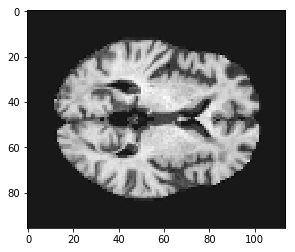

In [16]:
sample = adni_data_test[-1]
img = sample["image"]
print(img.shape)
plt.imshow(img[0][:,:,40], cmap='gray')

# Define the classifier

In [17]:
class SixtyFourNet(nn.Module):
    def __init__(self, drp_rate=0.3):
        super(SixtyFourNet, self).__init__()
        self.drp_rate = drp_rate
        self.dropout = nn.Dropout3d(p=self.drp_rate)
        self.Conv_1 = nn.Conv3d(1, 64, kernel_size=3, stride=1, padding=0)
        self.pool_1 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)
        self.Conv_2 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.pool_2 = nn.MaxPool3d(kernel_size=3, stride=2, padding=0)
        self.Conv_3 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.Conv_4 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.Conv_5 = nn.Conv3d(64, 36, kernel_size=3, stride=1, padding=0)
        self.pool_4 = nn.MaxPool3d(kernel_size=4, stride=2, padding=0)
        
        # 4, 64, 1, 2, 1
        self.classifier_scratch = nn.Sequential(
            #nn.Dropout(0.2),
            nn.Linear(1296, 80),
            #nn.Dropout(0.2),
            nn.Linear(80, 1)
        )

    def encode(self, x, print_size=False):
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_1(x))
        h = self.dropout(self.pool_1(x))
        x = F.elu(self.Conv_2(h))
        if print_size:
            print(x.shape)
        h = self.dropout(self.pool_2(x))
        x = F.elu(self.Conv_3(h))
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_4(x))
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_5(x))
        if print_size:
            print(x.shape)
        h = self.dropout(self.pool_4(x))
        if print_size:
            print(h.shape)
        
        return h

    def forward(self, x):
        print_size = False
        x = self.encode(x, print_size=print_size)
        x = self.flatten(x)
        x = self.classifier_scratch(x)
        return x
    
    def flatten(self, x):
        return x.view(x.size(0), -1)

In [18]:
if multi_gpus is None:
    net = SixtyFourNet().cuda(gpu)
else:
    net = torch.nn.DataParallel(SixtyFourNet(), device_ids=multi_gpus).cuda(gpu)

In [19]:
print(net)

SixtyFourNet(
  (dropout): Dropout3d(p=0.3)
  (Conv_1): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (pool_1): MaxPool3d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (Conv_2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (pool_2): MaxPool3d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv_3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (Conv_4): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (Conv_5): Conv3d(64, 36, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (pool_4): MaxPool3d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
  (classifier_scratch): Sequential(
    (0): Linear(in_features=1296, out_features=80, bias=True)
    (1): Linear(in_features=80, out_features=1, bias=True)
  )
)


In [20]:
print("Trainable model parameters: {}".format(count_parameters(net)))

Trainable model parameters: 499845


# Training

In [21]:
def run(
    net,
    data,
    shape,
    callbacks=[],
    augmentations=[],
    masked=False,
    metrics=[],
    k_folds=None,
    b=4,
    num_epochs=35,
    retain_metric=None
):      
   
    fold_metric = []
    models = []
    fold = 0
    initial_prepend = None
    
    #for train_idx, val_idx in kf.split(data):#, df["label"]):
    for trial in range(10):
        print("Starting trial {}".format(trial))

        # add current fold number to model checkpoint path
        if callbacks is not None:
            for idx, callback in enumerate(callbacks):
                if isinstance(callback, ModelCheckpoint):
                    if initial_prepend is None:
                        initial_prepend = callbacks[idx].prepend
                    callbacks[idx].prepend = initial_prepend + "cv_fold_{}_".format(fold)
        fold += 1

        # restart model
        del net
        net = SixtyFourNet().cuda(gpu)
        
        # reset hyperparameters
        lr = 1e-4
        wd = 1e-4
        criterion = nn.BCEWithLogitsLoss().cuda(gpu)
        optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
        
        #sched = optim.lr_scheduler.StepLR(optimizer, gamma=0.1, step_size=12)
        #sched = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.1, patience=5)

        train_loader = DataLoader(
            adni_data_train, batch_size=b, num_workers=4, sampler=train_sampler
        )
        val_loader = DataLoader(
            adni_data_val, batch_size=1, num_workers=1, shuffle=True
        )

        sample = next(iter(train_loader))
        img = sample["image"][0]
        lbl = sample["label"][0]
        print(img.shape)
        print(len(train_loader))
        plt.imshow(img.squeeze()[:,:,48], cmap='gray')
        plt.title(lbl.item())
        plt.show()
        trainer = Trainer(
            net,
            criterion,
            optimizer,
            metrics=metrics,
            callbacks=callbacks,
            device=gpu,
            #scheduler=sched,
        )
        # train model and store results
        net, report = trainer.train_model(
            train_loader,
            val_loader,
            num_epochs=num_epochs,
            show_train_steps=10,
            show_validation_epochs=1,
        )
        # append validation score of the retain metric
        if isinstance(retain_metric, str):
            fold_metric.append(report["val_metrics"][retain_metric][-1])
        else:
            fold_metric.append(report["val_metrics"][retain_metric.__name__][-1])

        models.append(net)
        print("Finished fold.")

        # visualize result
        trainer.visualize_training(report, metrics)
        trainer.evaluate_model(val_loader, gpu)

    print("################################")
    print("################################")
    print("All accuracies: {}".format(fold_metric))
    return fold_metric, models


In [22]:
num_epochs = 200
min_iters = 3
ignore_epochs = 65
normalize = False
retain_metric = balanced_accuracy
metrics = [accuracy_score, balanced_accuracy, auc_score]

In [23]:
r = 0

In [24]:
#output_dir = "/analysis/fabiane/models/MS/pretrained/from_keras/pytorch_finetuned/hdf5"
# ModelCheckpoint(path=output_dir,
                             #prepend="repeat_{}".format(r),
                             #store_best=True,
                             #ignore_before=ignore_epochs,
                             #retain_metric=retain_metric),
callbacks = [EarlyStopping(patience=12, ignore_before=ignore_epochs, retain_metric="loss", mode='min')]
#augmentations = [SagittalFlip(), SagittalTranslate(dist=(-2, 3))]

Starting trial 0
torch.Size([1, 96, 114, 96])
12


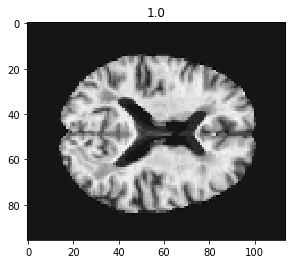

[0,    10] loss: 0.69055
Time elapsed: 0h:0m:4s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.725665
[1,    10] loss: 0.69090
Time elapsed: 0h:0m:11s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.729531
[2,    10] loss: 0.67789
Time elapsed: 0h:0m:17s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.731611
[3,    10] loss: 0.68798
Time elapsed: 0h:0m:24s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.745082
[4,    10] loss: 0.69232
Time elapsed: 0h:0m:31s


val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.714062
[35,    10] loss: 0.68347
Time elapsed: 0h:3m:56s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.719136
[36,    10] loss: 0.67445
Time elapsed: 0h:4m:2s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.739429
[37,    10] loss: 0.70211
Time elapsed: 0h:4m:9s
train accuracy_score: 44.60 %
train balanced_accuracy: 40.47 %
train auc_score: 40.47 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.714328
[38,    10] loss: 0.68106
Time elapsed: 0h:4m:15s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accur

[69,    10] loss: 0.57096
Time elapsed: 0h:7m:40s
train accuracy_score: 66.91 %
train balanced_accuracy: 64.51 %
train auc_score: 64.51 %
val accuracy_score: 84.00 %
val balanced_accuracy: 82.08 %
val auc_score: 82.08 %
Val loss: 0.390795
[70,    10] loss: 0.54695
Time elapsed: 0h:7m:46s
train accuracy_score: 67.63 %
train balanced_accuracy: 66.10 %
train auc_score: 66.10 %
val accuracy_score: 78.00 %
val balanced_accuracy: 81.25 %
val auc_score: 81.25 %
Val loss: 0.496843
[71,    10] loss: 0.54064
Time elapsed: 0h:7m:53s
train accuracy_score: 74.82 %
train balanced_accuracy: 74.97 %
train auc_score: 74.97 %
val accuracy_score: 43.00 %
val balanced_accuracy: 52.50 %
val auc_score: 52.50 %
Val loss: 0.869629
[72,    10] loss: 0.64181
Time elapsed: 0h:8m:0s
train accuracy_score: 71.94 %
train balanced_accuracy: 70.54 %
train auc_score: 70.54 %
val accuracy_score: 70.00 %
val balanced_accuracy: 74.17 %
val auc_score: 74.17 %
Val loss: 0.541531
[73,    10] loss: 0.48536
Time elapsed: 0h:8m

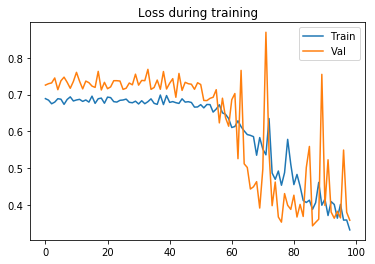

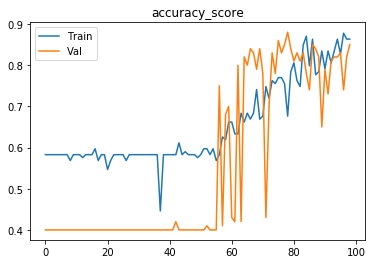

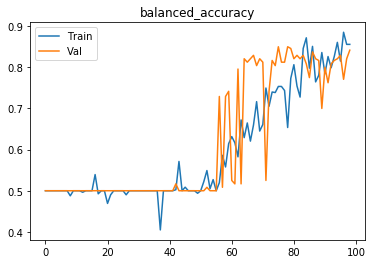

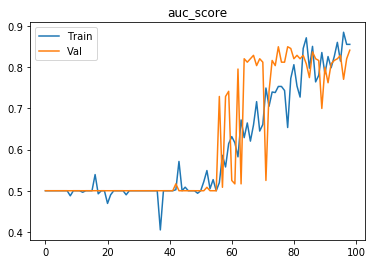

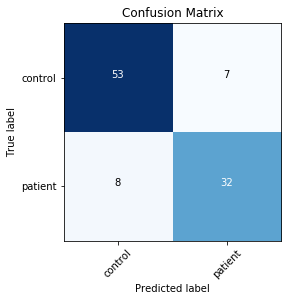

Starting trial 1
torch.Size([1, 96, 114, 96])
12


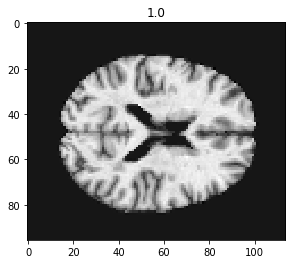

[0,    10] loss: 0.68651
Time elapsed: 0h:0m:4s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.731131
[1,    10] loss: 0.69680
Time elapsed: 0h:0m:11s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.736611
[2,    10] loss: 0.68630
Time elapsed: 0h:0m:17s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.724189
[3,    10] loss: 0.68009
Time elapsed: 0h:0m:24s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.717988
[4,    10] loss: 0.67548
Time elapsed: 0h:0m:31s


val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.733860
[35,    10] loss: 0.69227
Time elapsed: 0h:3m:55s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.733860
[36,    10] loss: 0.68392
Time elapsed: 0h:4m:1s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.715129
[37,    10] loss: 0.68121
Time elapsed: 0h:4m:8s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.742738
[38,    10] loss: 0.67725
Time elapsed: 0h:4m:15s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accur

[69,    10] loss: 0.65919
Time elapsed: 0h:7m:40s
train accuracy_score: 57.55 %
train balanced_accuracy: 55.99 %
train auc_score: 55.99 %
val accuracy_score: 42.00 %
val balanced_accuracy: 51.67 %
val auc_score: 51.67 %
Val loss: 0.671146
[70,    10] loss: 0.62367
Time elapsed: 0h:7m:47s
train accuracy_score: 66.91 %
train balanced_accuracy: 66.22 %
train auc_score: 66.22 %
val accuracy_score: 69.00 %
val balanced_accuracy: 74.17 %
val auc_score: 74.17 %
Val loss: 0.618231
[71,    10] loss: 0.62131
Time elapsed: 0h:7m:53s
train accuracy_score: 64.75 %
train balanced_accuracy: 59.96 %
train auc_score: 59.96 %
val accuracy_score: 78.00 %
val balanced_accuracy: 76.67 %
val auc_score: 76.67 %
Val loss: 0.542425
[72,    10] loss: 0.58880
Time elapsed: 0h:8m:0s
train accuracy_score: 69.06 %
train balanced_accuracy: 66.36 %
train auc_score: 66.36 %
val accuracy_score: 74.00 %
val balanced_accuracy: 74.17 %
val auc_score: 74.17 %
Val loss: 0.519950
[73,    10] loss: 0.56453
Time elapsed: 0h:8m

val accuracy_score: 88.00 %
val balanced_accuracy: 86.25 %
val auc_score: 86.25 %
Val loss: 0.389855
[104,    10] loss: 0.35205
Time elapsed: 0h:11m:30s
train accuracy_score: 87.77 %
train balanced_accuracy: 87.55 %
train auc_score: 87.55 %
val accuracy_score: 83.00 %
val balanced_accuracy: 82.92 %
val auc_score: 82.92 %
Val loss: 0.383922
Early stopping in epoch 105
Total time elapsed: 0h:11m:32s
Finished fold.


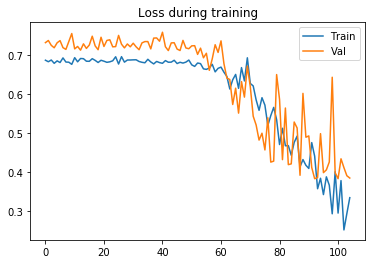

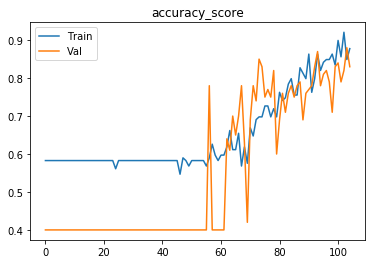

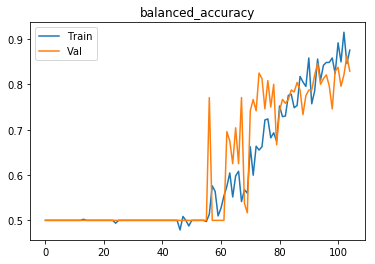

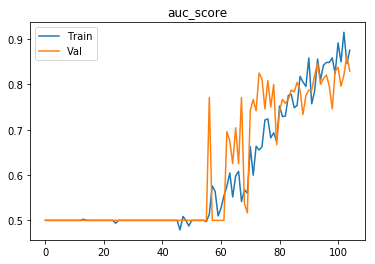

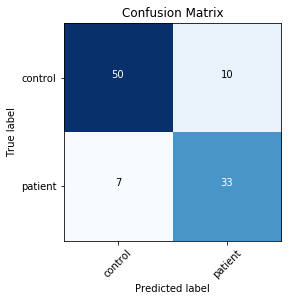

Starting trial 2
torch.Size([1, 96, 114, 96])
12


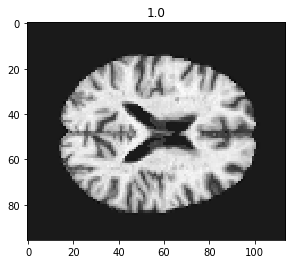

[0,    10] loss: 0.68446
Time elapsed: 0h:0m:4s
train accuracy_score: 57.55 %
train balanced_accuracy: 49.38 %
train auc_score: 49.38 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.746060
[1,    10] loss: 0.69458
Time elapsed: 0h:0m:11s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.703366
[2,    10] loss: 0.68758
Time elapsed: 0h:0m:17s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.714657
[3,    10] loss: 0.68719
Time elapsed: 0h:0m:24s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.734035
[4,    10] loss: 0.68267
Time elapsed: 0h:0m:30s


val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.737618
[35,    10] loss: 0.68938
Time elapsed: 0h:3m:55s
train accuracy_score: 54.68 %
train balanced_accuracy: 47.65 %
train auc_score: 47.65 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.719499
[36,    10] loss: 0.67789
Time elapsed: 0h:4m:2s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.724629
[37,    10] loss: 0.67992
Time elapsed: 0h:4m:8s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.710890
[38,    10] loss: 0.67547
Time elapsed: 0h:4m:15s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accur

[69,    10] loss: 0.55789
Time elapsed: 0h:7m:39s
train accuracy_score: 68.35 %
train balanced_accuracy: 67.45 %
train auc_score: 67.45 %
val accuracy_score: 67.00 %
val balanced_accuracy: 72.08 %
val auc_score: 72.08 %
Val loss: 0.583295
[70,    10] loss: 0.53014
Time elapsed: 0h:7m:46s
train accuracy_score: 71.22 %
train balanced_accuracy: 69.19 %
train auc_score: 69.19 %
val accuracy_score: 74.00 %
val balanced_accuracy: 76.67 %
val auc_score: 76.67 %
Val loss: 0.509306
[71,    10] loss: 0.56106
Time elapsed: 0h:7m:53s
train accuracy_score: 69.78 %
train balanced_accuracy: 67.95 %
train auc_score: 67.95 %
val accuracy_score: 75.00 %
val balanced_accuracy: 77.50 %
val auc_score: 77.50 %
Val loss: 0.497844
[72,    10] loss: 0.60651
Time elapsed: 0h:7m:59s
train accuracy_score: 71.22 %
train balanced_accuracy: 69.92 %
train auc_score: 69.92 %
val accuracy_score: 42.00 %
val balanced_accuracy: 51.67 %
val auc_score: 51.67 %
Val loss: 0.746453
[73,    10] loss: 0.58561
Time elapsed: 0h:8

val accuracy_score: 86.00 %
val balanced_accuracy: 85.83 %
val auc_score: 85.83 %
Val loss: 0.313115
[104,    10] loss: 0.42350
Time elapsed: 0h:11m:32s
train accuracy_score: 82.73 %
train balanced_accuracy: 82.00 %
train auc_score: 82.00 %
val accuracy_score: 88.00 %
val balanced_accuracy: 87.08 %
val auc_score: 87.08 %
Val loss: 0.308362
[105,    10] loss: 0.34317
Time elapsed: 0h:11m:39s
train accuracy_score: 84.89 %
train balanced_accuracy: 85.08 %
train auc_score: 85.08 %
val accuracy_score: 79.00 %
val balanced_accuracy: 80.83 %
val auc_score: 80.83 %
Val loss: 0.459765
[106,    10] loss: 0.33504
Time elapsed: 0h:11m:46s
train accuracy_score: 86.33 %
train balanced_accuracy: 85.82 %
train auc_score: 85.82 %
val accuracy_score: 72.00 %
val balanced_accuracy: 76.25 %
val auc_score: 76.25 %
Val loss: 0.593883
[107,    10] loss: 0.35445
Time elapsed: 0h:11m:53s
train accuracy_score: 86.33 %
train balanced_accuracy: 85.33 %
train auc_score: 85.33 %
val accuracy_score: 85.00 %
val bala

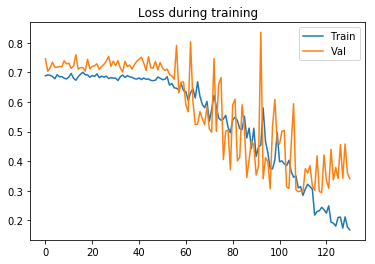

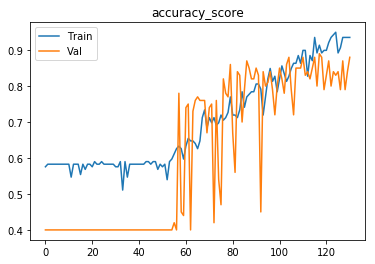

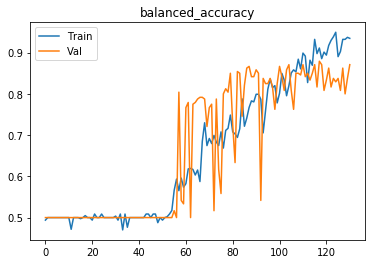

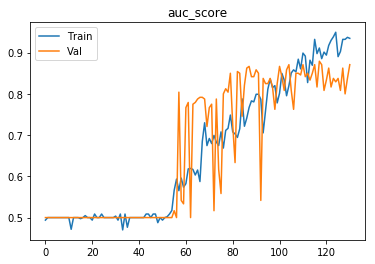

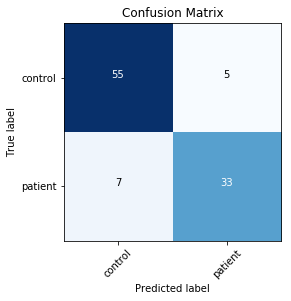

Starting trial 3
torch.Size([1, 96, 114, 96])
12


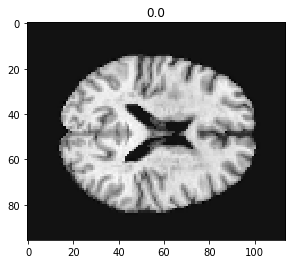

[0,    10] loss: 0.67378
Time elapsed: 0h:0m:4s
train accuracy_score: 53.96 %
train balanced_accuracy: 51.93 %
train auc_score: 51.93 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.837422
[1,    10] loss: 0.69491
Time elapsed: 0h:0m:11s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.709538
[2,    10] loss: 0.69606
Time elapsed: 0h:0m:18s
train accuracy_score: 57.55 %
train balanced_accuracy: 49.87 %
train auc_score: 49.87 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.724799
[3,    10] loss: 0.68774
Time elapsed: 0h:0m:24s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.24 %
train auc_score: 50.24 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.712879
[4,    10] loss: 0.68798
Time elapsed: 0h:0m:31s


val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.712949
[35,    10] loss: 0.68854
Time elapsed: 0h:3m:55s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.723531
[36,    10] loss: 0.67654
Time elapsed: 0h:4m:2s
train accuracy_score: 58.99 %
train balanced_accuracy: 51.11 %
train auc_score: 51.11 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.724612
[37,    10] loss: 0.68146
Time elapsed: 0h:4m:9s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.721768
[38,    10] loss: 0.68937
Time elapsed: 0h:4m:15s
train accuracy_score: 61.87 %
train balanced_accuracy: 55.04 %
train auc_score: 55.04 %
val accuracy_score: 40.00 %
val balanced_accur

[69,    10] loss: 0.46649
Time elapsed: 0h:7m:41s
train accuracy_score: 80.58 %
train balanced_accuracy: 78.93 %
train auc_score: 78.93 %
val accuracy_score: 84.00 %
val balanced_accuracy: 82.08 %
val auc_score: 82.08 %
Val loss: 0.386595
[70,    10] loss: 0.51076
Time elapsed: 0h:7m:47s
train accuracy_score: 78.42 %
train balanced_accuracy: 79.52 %
train auc_score: 79.52 %
val accuracy_score: 70.00 %
val balanced_accuracy: 75.00 %
val auc_score: 75.00 %
Val loss: 0.605458
[71,    10] loss: 0.60159
Time elapsed: 0h:7m:54s
train accuracy_score: 72.66 %
train balanced_accuracy: 71.65 %
train auc_score: 71.65 %
val accuracy_score: 76.00 %
val balanced_accuracy: 80.00 %
val auc_score: 80.00 %
Val loss: 0.520407
[72,    10] loss: 0.49100
Time elapsed: 0h:8m:0s
train accuracy_score: 74.10 %
train balanced_accuracy: 72.15 %
train auc_score: 72.15 %
val accuracy_score: 76.00 %
val balanced_accuracy: 78.75 %
val auc_score: 78.75 %
Val loss: 0.468179
[73,    10] loss: 0.43772
Time elapsed: 0h:8m

val accuracy_score: 77.00 %
val balanced_accuracy: 79.58 %
val auc_score: 79.58 %
Val loss: 0.575605
[104,    10] loss: 0.20914
Time elapsed: 0h:11m:33s
train accuracy_score: 90.65 %
train balanced_accuracy: 90.26 %
train auc_score: 90.26 %
val accuracy_score: 81.00 %
val balanced_accuracy: 81.25 %
val auc_score: 81.25 %
Val loss: 0.415553
[105,    10] loss: 0.25024
Time elapsed: 0h:11m:40s
train accuracy_score: 88.49 %
train balanced_accuracy: 87.92 %
train auc_score: 87.92 %
val accuracy_score: 80.00 %
val balanced_accuracy: 81.25 %
val auc_score: 81.25 %
Val loss: 0.444024
[106,    10] loss: 0.27051
Time elapsed: 0h:11m:46s
train accuracy_score: 88.49 %
train balanced_accuracy: 87.68 %
train auc_score: 87.68 %
val accuracy_score: 85.00 %
val balanced_accuracy: 83.75 %
val auc_score: 83.75 %
Val loss: 0.384556
Early stopping in epoch 107
Total time elapsed: 0h:11m:48s
Finished fold.


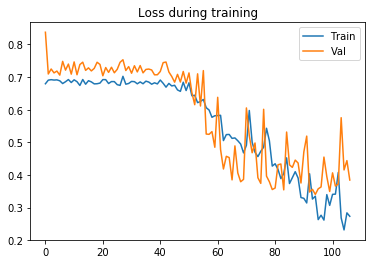

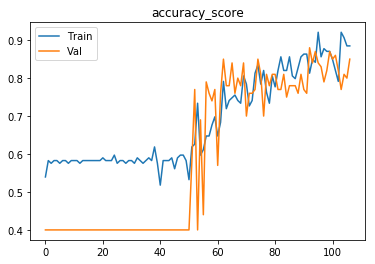

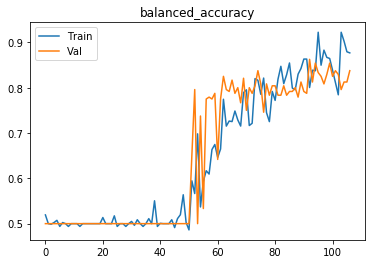

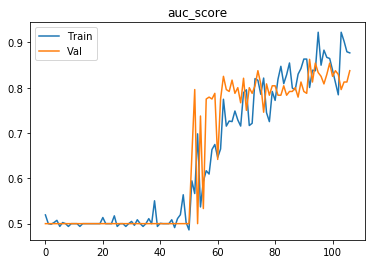

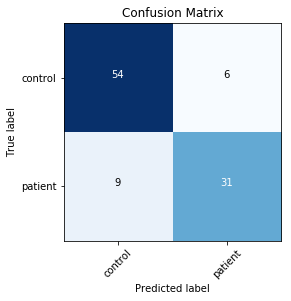

Starting trial 4
torch.Size([1, 96, 114, 96])
12


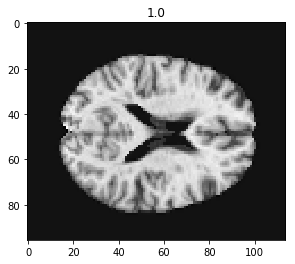

[0,    10] loss: 0.68243
Time elapsed: 0h:0m:4s
train accuracy_score: 57.55 %
train balanced_accuracy: 49.38 %
train auc_score: 49.38 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.743530
[1,    10] loss: 0.68633
Time elapsed: 0h:0m:11s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.710800
[2,    10] loss: 0.68163
Time elapsed: 0h:0m:17s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.742539
[3,    10] loss: 0.69676
Time elapsed: 0h:0m:24s
train accuracy_score: 56.83 %
train balanced_accuracy: 48.77 %
train auc_score: 48.77 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.724185
[4,    10] loss: 0.68579
Time elapsed: 0h:0m:31s


val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.729845
[35,    10] loss: 0.69055
Time elapsed: 0h:3m:55s
train accuracy_score: 57.55 %
train balanced_accuracy: 49.38 %
train auc_score: 49.38 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.727152
[36,    10] loss: 0.67873
Time elapsed: 0h:4m:2s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.755570
[37,    10] loss: 0.69404
Time elapsed: 0h:4m:8s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.703473
[38,    10] loss: 0.67852
Time elapsed: 0h:4m:15s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accur

[69,    10] loss: 0.51059
Time elapsed: 0h:7m:39s
train accuracy_score: 76.26 %
train balanced_accuracy: 74.98 %
train auc_score: 74.98 %
val accuracy_score: 76.00 %
val balanced_accuracy: 78.75 %
val auc_score: 78.75 %
Val loss: 0.473626
[70,    10] loss: 0.48160
Time elapsed: 0h:7m:46s
train accuracy_score: 82.01 %
train balanced_accuracy: 81.14 %
train auc_score: 81.14 %
val accuracy_score: 81.00 %
val balanced_accuracy: 82.50 %
val auc_score: 82.50 %
Val loss: 0.425953
[71,    10] loss: 0.48862
Time elapsed: 0h:7m:52s
train accuracy_score: 76.98 %
train balanced_accuracy: 75.60 %
train auc_score: 75.60 %
val accuracy_score: 77.00 %
val balanced_accuracy: 79.58 %
val auc_score: 79.58 %
Val loss: 0.430549
[72,    10] loss: 0.45396
Time elapsed: 0h:7m:59s
train accuracy_score: 79.14 %
train balanced_accuracy: 78.18 %
train auc_score: 78.18 %
val accuracy_score: 83.00 %
val balanced_accuracy: 83.75 %
val auc_score: 83.75 %
Val loss: 0.374914
[73,    10] loss: 0.49428
Time elapsed: 0h:8

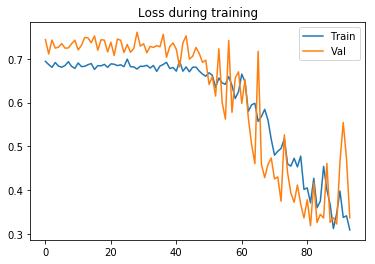

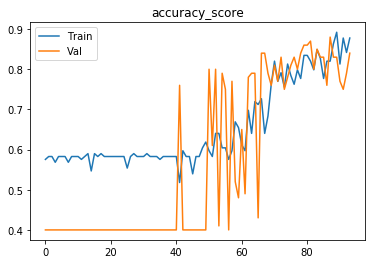

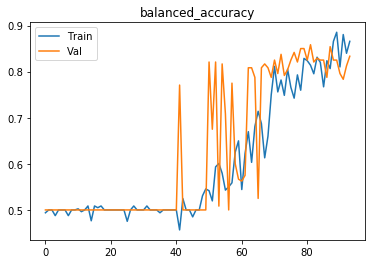

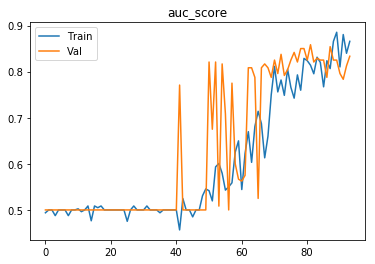

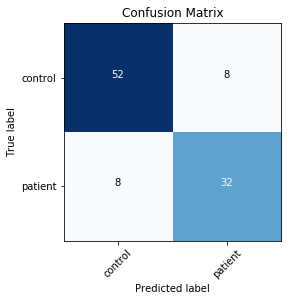

Starting trial 5
torch.Size([1, 96, 114, 96])
12


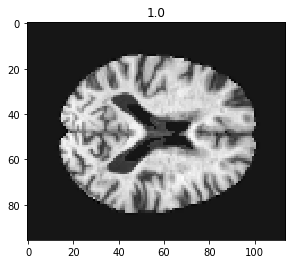

[0,    10] loss: 0.68508
Time elapsed: 0h:0m:4s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.24 %
train auc_score: 50.24 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.757597
[1,    10] loss: 0.69127
Time elapsed: 0h:0m:10s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.712892
[2,    10] loss: 0.68565
Time elapsed: 0h:0m:17s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.737411
[3,    10] loss: 0.68367
Time elapsed: 0h:0m:24s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.719348
[4,    10] loss: 0.68788
Time elapsed: 0h:0m:30s


val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.720433
[35,    10] loss: 0.67452
Time elapsed: 0h:3m:54s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.739160
[36,    10] loss: 0.67817
Time elapsed: 0h:4m:1s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.740090
[37,    10] loss: 0.67255
Time elapsed: 0h:4m:7s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.753694
[38,    10] loss: 0.67019
Time elapsed: 0h:4m:14s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accur

[69,    10] loss: 0.55065
Time elapsed: 0h:7m:40s
train accuracy_score: 71.22 %
train balanced_accuracy: 69.68 %
train auc_score: 69.68 %
val accuracy_score: 77.00 %
val balanced_accuracy: 78.75 %
val auc_score: 78.75 %
Val loss: 0.504161
[70,    10] loss: 0.58660
Time elapsed: 0h:7m:46s
train accuracy_score: 67.63 %
train balanced_accuracy: 66.35 %
train auc_score: 66.35 %
val accuracy_score: 76.00 %
val balanced_accuracy: 75.83 %
val auc_score: 75.83 %
Val loss: 0.461975
[71,    10] loss: 0.56602
Time elapsed: 0h:7m:53s
train accuracy_score: 72.66 %
train balanced_accuracy: 71.16 %
train auc_score: 71.16 %
val accuracy_score: 76.00 %
val balanced_accuracy: 79.17 %
val auc_score: 79.17 %
Val loss: 0.532724
[72,    10] loss: 0.55184
Time elapsed: 0h:8m:0s
train accuracy_score: 69.78 %
train balanced_accuracy: 68.44 %
train auc_score: 68.44 %
val accuracy_score: 77.00 %
val balanced_accuracy: 76.25 %
val auc_score: 76.25 %
Val loss: 0.444031
[73,    10] loss: 0.52565
Time elapsed: 0h:8m

val accuracy_score: 84.00 %
val balanced_accuracy: 82.92 %
val auc_score: 82.92 %
Val loss: 0.356101
[104,    10] loss: 0.33046
Time elapsed: 0h:11m:32s
train accuracy_score: 85.61 %
train balanced_accuracy: 85.94 %
train auc_score: 85.94 %
val accuracy_score: 82.00 %
val balanced_accuracy: 83.33 %
val auc_score: 83.33 %
Val loss: 0.477927
[105,    10] loss: 0.36209
Time elapsed: 0h:11m:39s
train accuracy_score: 84.89 %
train balanced_accuracy: 85.08 %
train auc_score: 85.08 %
val accuracy_score: 79.00 %
val balanced_accuracy: 81.25 %
val auc_score: 81.25 %
Val loss: 0.470284
[106,    10] loss: 0.31050
Time elapsed: 0h:11m:45s
train accuracy_score: 87.77 %
train balanced_accuracy: 86.81 %
train auc_score: 86.81 %
val accuracy_score: 80.00 %
val balanced_accuracy: 80.42 %
val auc_score: 80.42 %
Val loss: 0.391387
[107,    10] loss: 0.29352
Time elapsed: 0h:11m:52s
train accuracy_score: 88.49 %
train balanced_accuracy: 88.41 %
train auc_score: 88.41 %
val accuracy_score: 82.00 %
val bala

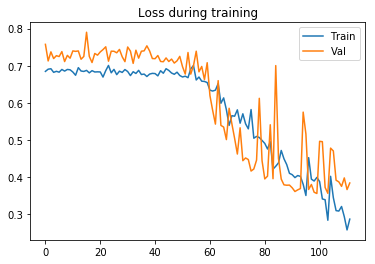

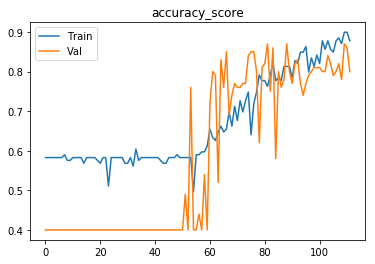

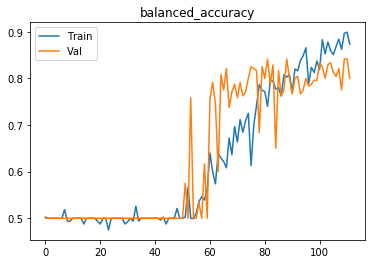

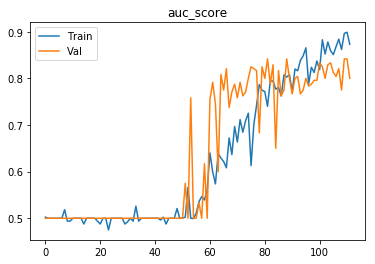

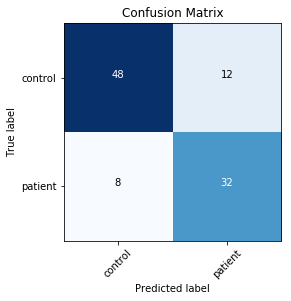

Starting trial 6
torch.Size([1, 96, 114, 96])
12


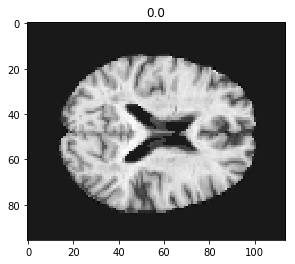

[0,    10] loss: 0.69266
Time elapsed: 0h:0m:4s
train accuracy_score: 58.99 %
train balanced_accuracy: 50.86 %
train auc_score: 50.86 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.712983
[1,    10] loss: 0.68344
Time elapsed: 0h:0m:11s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.741194
[2,    10] loss: 0.67842
Time elapsed: 0h:0m:17s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.743864
[3,    10] loss: 0.68610
Time elapsed: 0h:0m:24s
train accuracy_score: 59.71 %
train balanced_accuracy: 51.72 %
train auc_score: 51.72 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.721074
[4,    10] loss: 0.68024
Time elapsed: 0h:0m:30s


val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.728175
[35,    10] loss: 0.67300
Time elapsed: 0h:3m:57s
train accuracy_score: 61.87 %
train balanced_accuracy: 57.00 %
train auc_score: 57.00 %
val accuracy_score: 42.00 %
val balanced_accuracy: 51.67 %
val auc_score: 51.67 %
Val loss: 0.687229
[36,    10] loss: 0.66915
Time elapsed: 0h:4m:4s
train accuracy_score: 58.99 %
train balanced_accuracy: 51.84 %
train auc_score: 51.84 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.723869
[37,    10] loss: 0.65985
Time elapsed: 0h:4m:10s
train accuracy_score: 60.43 %
train balanced_accuracy: 52.83 %
train auc_score: 52.83 %
val accuracy_score: 68.00 %
val balanced_accuracy: 72.50 %
val auc_score: 72.50 %
Val loss: 0.661920
[38,    10] loss: 0.67213
Time elapsed: 0h:4m:17s
train accuracy_score: 54.68 %
train balanced_accuracy: 52.54 %
train auc_score: 52.54 %
val accuracy_score: 40.00 %
val balanced_accu

[69,    10] loss: 0.41909
Time elapsed: 0h:7m:43s
train accuracy_score: 78.42 %
train balanced_accuracy: 77.56 %
train auc_score: 77.56 %
val accuracy_score: 77.00 %
val balanced_accuracy: 78.33 %
val auc_score: 78.33 %
Val loss: 0.464859
[70,    10] loss: 0.42100
Time elapsed: 0h:7m:50s
train accuracy_score: 80.58 %
train balanced_accuracy: 79.42 %
train auc_score: 79.42 %
val accuracy_score: 75.00 %
val balanced_accuracy: 75.00 %
val auc_score: 75.00 %
Val loss: 0.402398
[71,    10] loss: 0.38243
Time elapsed: 0h:7m:57s
train accuracy_score: 82.01 %
train balanced_accuracy: 81.39 %
train auc_score: 81.39 %
val accuracy_score: 75.00 %
val balanced_accuracy: 75.00 %
val auc_score: 75.00 %
Val loss: 0.408477
[72,    10] loss: 0.43854
Time elapsed: 0h:8m:4s
train accuracy_score: 81.29 %
train balanced_accuracy: 80.03 %
train auc_score: 80.03 %
val accuracy_score: 75.00 %
val balanced_accuracy: 75.00 %
val auc_score: 75.00 %
Val loss: 0.428546
[73,    10] loss: 0.41543
Time elapsed: 0h:8m

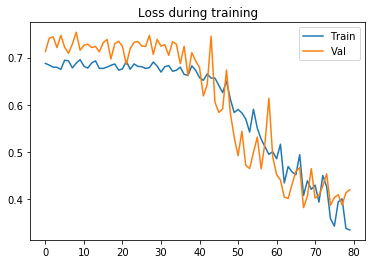

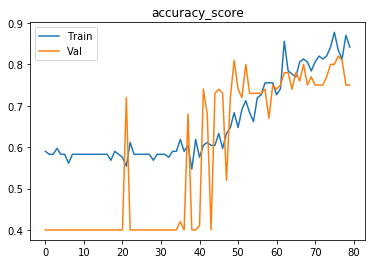

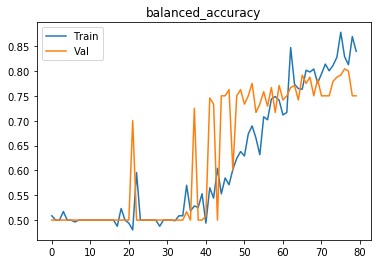

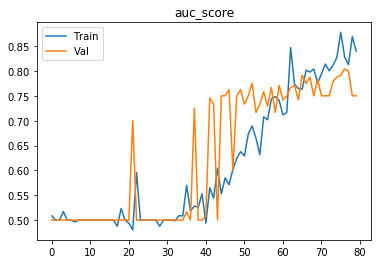

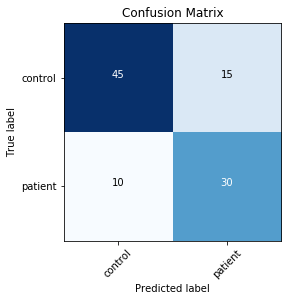

Starting trial 7
torch.Size([1, 96, 114, 96])
12


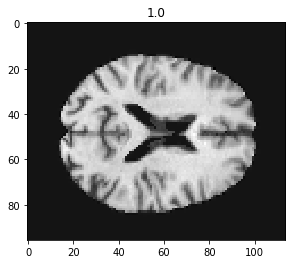

[0,    10] loss: 0.69419
Time elapsed: 0h:0m:4s
train accuracy_score: 55.40 %
train balanced_accuracy: 48.27 %
train auc_score: 48.27 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.726519
[1,    10] loss: 0.68833
Time elapsed: 0h:0m:11s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.708239
[2,    10] loss: 0.68162
Time elapsed: 0h:0m:17s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.742571
[3,    10] loss: 0.67969
Time elapsed: 0h:0m:24s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.721787
[4,    10] loss: 0.67954
Time elapsed: 0h:0m:31s


val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.741009
[35,    10] loss: 0.68291
Time elapsed: 0h:3m:57s
train accuracy_score: 58.99 %
train balanced_accuracy: 51.11 %
train auc_score: 51.11 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.701974
[36,    10] loss: 0.67280
Time elapsed: 0h:4m:4s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.735935
[37,    10] loss: 0.67351
Time elapsed: 0h:4m:10s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.745756
[38,    10] loss: 0.68721
Time elapsed: 0h:4m:17s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accu

[69,    10] loss: 0.47611
Time elapsed: 0h:7m:43s
train accuracy_score: 76.98 %
train balanced_accuracy: 75.35 %
train auc_score: 75.35 %
val accuracy_score: 74.00 %
val balanced_accuracy: 77.50 %
val auc_score: 77.50 %
Val loss: 0.470666
[70,    10] loss: 0.48929
Time elapsed: 0h:7m:50s
train accuracy_score: 76.26 %
train balanced_accuracy: 74.98 %
train auc_score: 74.98 %
val accuracy_score: 68.00 %
val balanced_accuracy: 72.92 %
val auc_score: 72.92 %
Val loss: 0.546265
[71,    10] loss: 0.47919
Time elapsed: 0h:7m:57s
train accuracy_score: 76.26 %
train balanced_accuracy: 75.71 %
train auc_score: 75.71 %
val accuracy_score: 68.00 %
val balanced_accuracy: 72.92 %
val auc_score: 72.92 %
Val loss: 0.543262
[72,    10] loss: 0.45795
Time elapsed: 0h:8m:3s
train accuracy_score: 79.86 %
train balanced_accuracy: 78.55 %
train auc_score: 78.55 %
val accuracy_score: 73.00 %
val balanced_accuracy: 77.08 %
val auc_score: 77.08 %
Val loss: 0.492898
[73,    10] loss: 0.48579
Time elapsed: 0h:8m

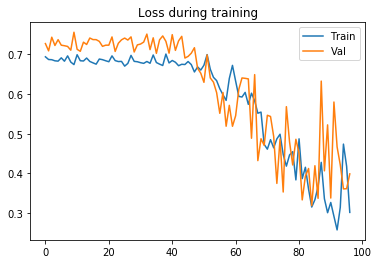

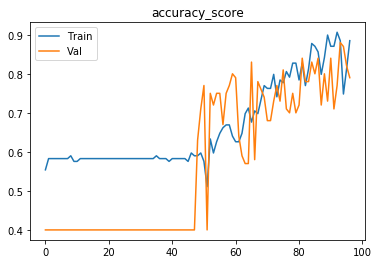

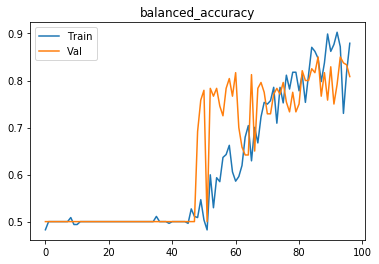

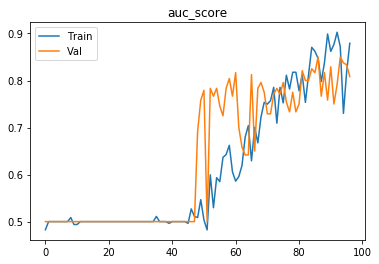

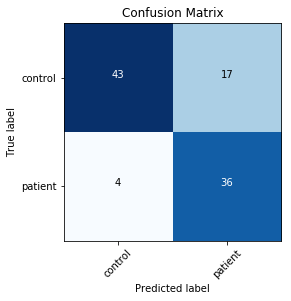

Starting trial 8
torch.Size([1, 96, 114, 96])
12


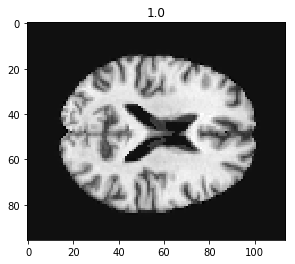

[0,    10] loss: 0.68713
Time elapsed: 0h:0m:4s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.717485
[1,    10] loss: 0.68971
Time elapsed: 0h:0m:11s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.735209
[2,    10] loss: 0.68057
Time elapsed: 0h:0m:17s
train accuracy_score: 58.99 %
train balanced_accuracy: 50.86 %
train auc_score: 50.86 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.748953
[3,    10] loss: 0.68625
Time elapsed: 0h:0m:24s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.728531
[4,    10] loss: 0.67408
Time elapsed: 0h:0m:31s


val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.742261
[35,    10] loss: 0.68007
Time elapsed: 0h:3m:57s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.728272
[36,    10] loss: 0.68842
Time elapsed: 0h:4m:3s
train accuracy_score: 57.55 %
train balanced_accuracy: 49.38 %
train auc_score: 49.38 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.732053
[37,    10] loss: 0.68088
Time elapsed: 0h:4m:10s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.742097
[38,    10] loss: 0.68618
Time elapsed: 0h:4m:16s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accu

[69,    10] loss: 0.60335
Time elapsed: 0h:7m:43s
train accuracy_score: 65.47 %
train balanced_accuracy: 61.31 %
train auc_score: 61.31 %
val accuracy_score: 68.00 %
val balanced_accuracy: 60.42 %
val auc_score: 60.42 %
Val loss: 0.558901
[70,    10] loss: 0.57577
Time elapsed: 0h:7m:49s
train accuracy_score: 67.63 %
train balanced_accuracy: 65.86 %
train auc_score: 65.86 %
val accuracy_score: 58.00 %
val balanced_accuracy: 65.00 %
val auc_score: 65.00 %
Val loss: 0.656336
[71,    10] loss: 0.63198
Time elapsed: 0h:7m:56s
train accuracy_score: 66.19 %
train balanced_accuracy: 65.36 %
train auc_score: 65.36 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.752591
[72,    10] loss: 0.70461
Time elapsed: 0h:8m:2s
train accuracy_score: 57.55 %
train balanced_accuracy: 55.26 %
train auc_score: 55.26 %
val accuracy_score: 41.00 %
val balanced_accuracy: 50.83 %
val auc_score: 50.83 %
Val loss: 0.714017
[73,    10] loss: 0.62235
Time elapsed: 0h:8m

val accuracy_score: 84.00 %
val balanced_accuracy: 82.50 %
val auc_score: 82.50 %
Val loss: 0.408589
[104,    10] loss: 0.33556
Time elapsed: 0h:11m:36s
train accuracy_score: 86.33 %
train balanced_accuracy: 85.82 %
train auc_score: 85.82 %
val accuracy_score: 86.00 %
val balanced_accuracy: 84.17 %
val auc_score: 84.17 %
Val loss: 0.418844
[105,    10] loss: 0.35190
Time elapsed: 0h:11m:42s
train accuracy_score: 82.73 %
train balanced_accuracy: 82.25 %
train auc_score: 82.25 %
val accuracy_score: 76.00 %
val balanced_accuracy: 77.08 %
val auc_score: 77.08 %
Val loss: 0.506048
[106,    10] loss: 0.33265
Time elapsed: 0h:11m:49s
train accuracy_score: 83.45 %
train balanced_accuracy: 83.60 %
train auc_score: 83.60 %
val accuracy_score: 71.00 %
val balanced_accuracy: 73.33 %
val auc_score: 73.33 %
Val loss: 0.576125
[107,    10] loss: 0.29095
Time elapsed: 0h:11m:56s
train accuracy_score: 89.21 %
train balanced_accuracy: 88.29 %
train auc_score: 88.29 %
val accuracy_score: 84.00 %
val bala

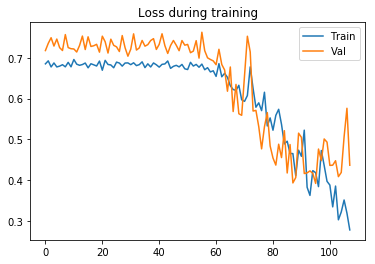

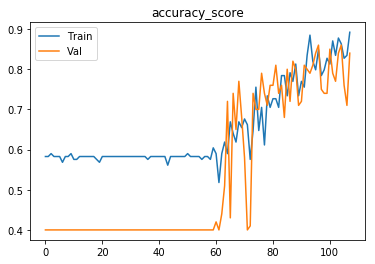

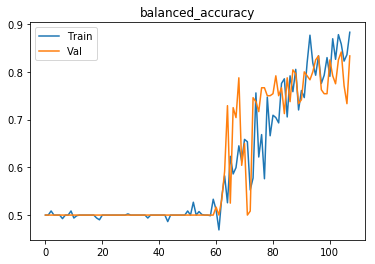

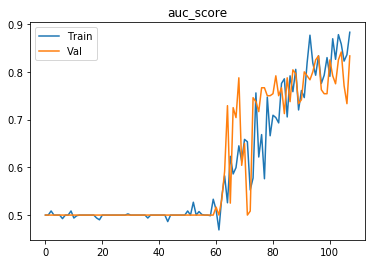

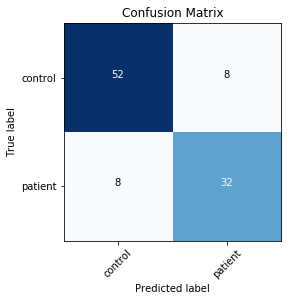

Starting trial 9
torch.Size([1, 96, 114, 96])
12


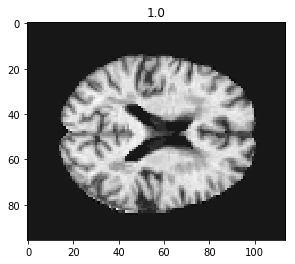

[0,    10] loss: 0.69079
Time elapsed: 0h:0m:4s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.731879
[1,    10] loss: 0.68527
Time elapsed: 0h:0m:11s
train accuracy_score: 57.55 %
train balanced_accuracy: 49.38 %
train auc_score: 49.38 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.731470
[2,    10] loss: 0.67468
Time elapsed: 0h:0m:18s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.742214
[3,    10] loss: 0.67980
Time elapsed: 0h:0m:24s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.716497
[4,    10] loss: 0.68601
Time elapsed: 0h:0m:31s


val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.728821
[35,    10] loss: 0.67154
Time elapsed: 0h:3m:57s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.761618
[36,    10] loss: 0.68102
Time elapsed: 0h:4m:4s
train accuracy_score: 58.27 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.734022
[37,    10] loss: 0.67060
Time elapsed: 0h:4m:10s
train accuracy_score: 57.55 %
train balanced_accuracy: 49.38 %
train auc_score: 49.38 %
val accuracy_score: 40.00 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.731458
[38,    10] loss: 0.68448
Time elapsed: 0h:4m:17s
train accuracy_score: 57.55 %
train balanced_accuracy: 50.12 %
train auc_score: 50.12 %
val accuracy_score: 40.00 %
val balanced_accu

[69,    10] loss: 0.58567
Time elapsed: 0h:7m:43s
train accuracy_score: 67.63 %
train balanced_accuracy: 63.90 %
train auc_score: 63.90 %
val accuracy_score: 72.00 %
val balanced_accuracy: 74.17 %
val auc_score: 74.17 %
Val loss: 0.546075
[70,    10] loss: 0.62332
Time elapsed: 0h:7m:50s
train accuracy_score: 59.71 %
train balanced_accuracy: 55.89 %
train auc_score: 55.89 %
val accuracy_score: 77.00 %
val balanced_accuracy: 75.42 %
val auc_score: 75.42 %
Val loss: 0.498205
[71,    10] loss: 0.63839
Time elapsed: 0h:7m:56s
train accuracy_score: 58.99 %
train balanced_accuracy: 56.74 %
train auc_score: 56.74 %
val accuracy_score: 75.00 %
val balanced_accuracy: 74.17 %
val auc_score: 74.17 %
Val loss: 0.521980
[72,    10] loss: 0.58152
Time elapsed: 0h:8m:3s
train accuracy_score: 71.94 %
train balanced_accuracy: 70.05 %
train auc_score: 70.05 %
val accuracy_score: 75.00 %
val balanced_accuracy: 74.17 %
val auc_score: 74.17 %
Val loss: 0.501131
[73,    10] loss: 0.59773
Time elapsed: 0h:8m

val accuracy_score: 78.00 %
val balanced_accuracy: 78.33 %
val auc_score: 78.33 %
Val loss: 0.376864
[104,    10] loss: 0.38533
Time elapsed: 0h:11m:36s
train accuracy_score: 80.58 %
train balanced_accuracy: 80.40 %
train auc_score: 80.40 %
val accuracy_score: 83.00 %
val balanced_accuracy: 81.67 %
val auc_score: 81.67 %
Val loss: 0.365563
[105,    10] loss: 0.33677
Time elapsed: 0h:11m:42s
train accuracy_score: 82.73 %
train balanced_accuracy: 81.76 %
train auc_score: 81.76 %
val accuracy_score: 78.00 %
val balanced_accuracy: 78.33 %
val auc_score: 78.33 %
Val loss: 0.386070
[106,    10] loss: 0.39525
Time elapsed: 0h:11m:49s
train accuracy_score: 79.86 %
train balanced_accuracy: 79.04 %
train auc_score: 79.04 %
val accuracy_score: 77.00 %
val balanced_accuracy: 77.08 %
val auc_score: 77.08 %
Val loss: 0.369643
Early stopping in epoch 107
Total time elapsed: 0h:11m:51s
Finished fold.


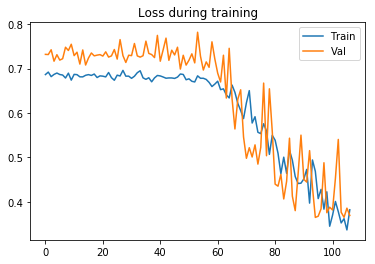

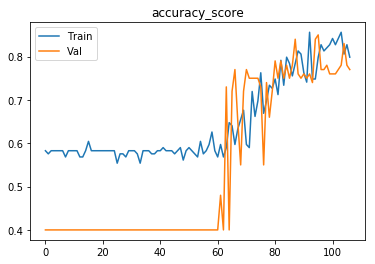

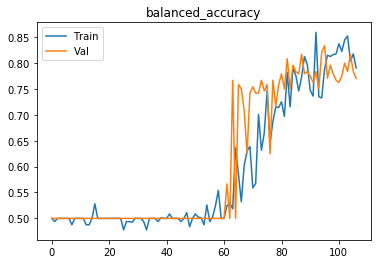

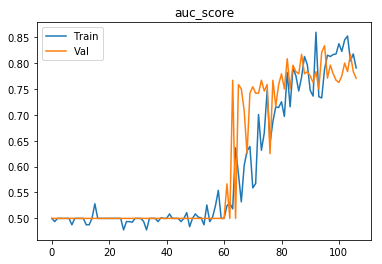

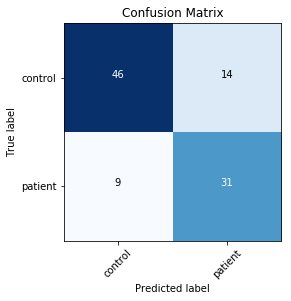

################################
################################
All accuracies: [0.8416666666666667, 0.8291666666666666, 0.8708333333333332, 0.8375, 0.8333333333333335, 0.8, 0.75, 0.8083333333333332, 0.8333333333333335, 0.7708333333333335]
0.8175000000000001
0.034044497026359144


In [25]:
fold_metric, models = run(net=net, data=adni_data_train,
                  k_folds=-1,
                  callbacks=callbacks,
                  shape=-1,
                  masked=False,
                  metrics=metrics,
                  num_epochs=num_epochs,
                  retain_metric=retain_metric,
                  b=b
                 )

print(np.mean(fold_metric))
print(np.std(fold_metric))

In [26]:
5/0

ZeroDivisionError: division by zero

# Start inference

In [27]:
test_loader = DataLoader(
            adni_data_test, batch_size=1, num_workers=1, shuffle=True
)

In [28]:
metrics = []
aucs = []
lr = 1e-5
wd = 1e-3
criterion = nn.BCEWithLogitsLoss().cuda(gpu)
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
    
for fold, model in enumerate(models):
    print("Fold {}".format(fold))

    all_preds = []
    all_labels = []
    
    net = model.cuda(gpu)
    net.eval()
    with torch.no_grad():
        for sample in test_loader:
            img = sample["image"]
            label = sample["label"]

            img = img.to(torch.device("cuda:" + str(gpu)))

            output = net.forward(img)
            pred = torch.sigmoid(output) >= 0.5
            all_preds.append(pred.cpu().numpy().item())
            all_labels.append(label.numpy().item())
    
    #print(all_preds)
    #print(all_labels)
    balanced_acc = balanced_accuracy(all_labels, all_preds)
    print(balanced_acc)
    
    fpr, tpr, thresholds = roc_curve(all_labels, all_preds, pos_label=2)
    this_auc = auc(fpr, tpr)
    print(this_auc)
    aucs.append(this_auc)
    '''trainer = Trainer(
                net,
                criterion,
                optimizer,
                scheduler=None,
                metrics=metrics,
                callbacks=None,
                device=gpu,
                prediction_type="binary"
            )
    computed_metrics = trainer.evaluate_model(test_loader, metrics=[balanced_accuracy])'''
    net.train()
    metrics.append(balanced_acc)
print("######## Final results ########")
metrics_df = pd.DataFrame(metrics)
print(metrics_df)
print("Balanced accuracy mean {:.2f} %".format(np.mean(metrics_df[0])*100))
print("Balanced accuracy std {:.2f} %".format(np.std(metrics_df[0])*100))
print("AUC mean {}:.2f %".format(np.mean(aucs)))

Fold 0
0.7938831615120274
nan
Fold 1


/home/fabiane/.local/lib/python3.6/site-packages/sklearn/metrics/ranking.py:651: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


0.8551202749140894
nan
Fold 2
0.7981443298969072
nan
Fold 3
0.8336082474226805
nan
Fold 4
0.7962886597938144
nan
Fold 5
0.8196563573883162
nan
Fold 6
0.7711340206185567
nan
Fold 7
0.7956701030927835
nan
Fold 8
0.8057044673539518
nan
Fold 9
0.8396563573883162
nan
######## Final results ########
          0
0  0.793883
1  0.855120
2  0.798144
3  0.833608
4  0.796289
5  0.819656
6  0.771134
7  0.795670
8  0.805704
9  0.839656
Balanced accuracy mean 81.09 %
Balanced accuracy std 2.43 %
AUC mean nan:.2f %


In [ ]:
for i, m in enumerate(models):
    print(i)
    for param in m.parameters():
        print(param.grad.norm(2))

In [ ]:
all_weight_norms = {}
all_bias_norms = {}
for i, m in enumerate(models):
    bias_norms = {}
    weight_norms = {}
    print(i)
    for name, param in m.named_parameters():
        #norms.append(param.grad.norm(2))
        norm = param.grad.norm(2)
        if name.endswith("bias"):
            name = name.replace(".bias", "")
            bias_norms["layer_{}".format(name)] = norm
        elif name.endswith("weight"):
            name = name.replace(".weight", "")
            weight_norms["layer_{}".format(name)] = norm
    all_weight_norms["fold_{}".format(i)] = weight_norms
    all_bias_norms["fold_{}".format(i)] = bias_norms

In [ ]:
list(metrics_df["balanced_accuracy"])

In [ ]:
num_cols = 2
num_rows = 4
plt.figure()
c = 1
r = 1

plt.figure(figsize=(12, 24))
plt.subplots_adjust(hspace=0.9, wspace=0.2)
for f in range(len(models)):
    plt.subplot(num_rows, num_cols, f+1)
    plt.plot(*zip(*sorted(all_weight_norms["fold_{}".format(f)].items())))
    plt.plot(*zip(*sorted(all_bias_norms["fold_{}".format(f)].items())))
    plt.legend(["Weights", "Biases"])
    plt.title("Fold {} Test balanced acc {:.2f}".format(f, metrics_df["balanced_accuracy"][f]))
    plt.xticks(rotation=90)
    axes = plt.gca()
    axes.set_ylim([0, 1])
    c += 1
plt.show()
    